In [ ]:
!sudo apt install parallel

In [ ]:
!pip install matplotlib

In [ ]:
!pip install transformers

In [ ]:
# Annotation Data
!wget https://people.cs.pitt.edu/~kovashka/ads/annotations_images.zip

In [ ]:
!sudo apt install unzip

In [ ]:
!unzip annotations_images.zip

In [ ]:
!pip install tqdm

In [1]:
# Get Images (Run in Linux Shell - Preferred)
# !parallel wget https://storage.googleapis.com/ads-dataset/subfolder-{}.zip ::: {1..10}

In [6]:
import zipfile
import os
from concurrent.futures import ThreadPoolExecutor

def unzip_zip_file(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Extracted {zip_path}")

def unzip_all_zip_files(directory, num_files, output_dir):
    with ThreadPoolExecutor() as executor:
        for i in range(0, num_files + 1):
            zip_file = f"subfolder-{i}.zip"
            zip_path = os.path.join(directory, zip_file)
            if os.path.exists(zip_path):
                executor.submit(unzip_zip_file, zip_path, output_dir)
            else:
                print(f"Zip file {zip_file} not found.")

directory = ''
num_files = 10
output_dir = 'images'

unzip_all_zip_files(directory, num_files, output_dir)

Extracted subfolder-1.zip
Extracted subfolder-8.zip
Extracted subfolder-6.zip
Extracted subfolder-0.zip
Extracted subfolder-3.zip
Extracted subfolder-5.zip
Extracted subfolder-9.zip
Extracted subfolder-4.zip
Extracted subfolder-7.zip
Extracted subfolder-2.zip
Extracted subfolder-10.zip


In [41]:
import json
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIPModel.from_pretrained('openai/clip-vit-large-patch14')
model.to(device)
processor = CLIPProcessor.from_pretrained('openai/clip-vit-large-patch14')

In [11]:
!nvidia-smi

Tue Feb  6 15:45:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:42:00.0 Off |                  Off |
|  0%   15C    P0              65W / 300W |   2050MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
import json
with open('image/QA_Action.json', 'r') as f:
    data = json.load(f)

In [13]:
dataset = []
folder = 'images/'

for image, action in data.items():
  dataset.append({'image_path': folder+image,
                  'title' : action[0]})

In [14]:
dataset[1805]

{'image_path': 'images/2/105492.jpg', 'title': 'i should buy neutrogena'}

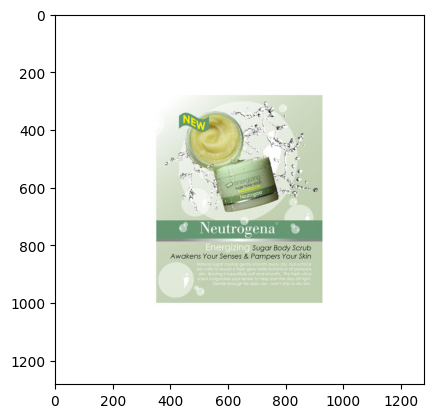

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

test_img = Image.open(dataset[1805]['image_path'])

plt.imshow(test_img)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        text = 'Ad Creative'
        label = 0
        inputs_dict = processor(text=["Ad Creative"], images=img, return_tensors="pt", padding=True)
        return inputs_dict, label


train_dataset = CustomDataset(dataset[:4000])

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [8]:
!nvidia-smi

Tue Feb  6 15:44:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:42:00.0 Off |                  Off |
|  0%   13C    P8              20W / 300W |      4MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
len(dataloader)

125

In [2]:
# Script to run distributed training
!python -m torch.distributed.launch --nproc_per_node=2 --nnodes=1 --node_rank=0 --master_port=1234 CLIP_ddp.py

191it [12:07,  3.68s/it]
Epoch 1 loss: 4.1529, accuracy: 95.0
Model saved after epoch 1.
196it [12:23,  3.79s/it]
Epoch 2 loss: 2.0004, accuracy: 99.00
Model saved after epoch 2.
196it [12:22,  3.79s/it]
Epoch 3 loss: 0.4228, accuracy: 100.00
Model saved after epoch 3.


In [ ]:
from dataset import eval_dataloader
dataloader = eval_dataloader

In [66]:
state_dict = torch.load('/Adv_CLIP/model_epoch_2.pth')

# # original saved file with DataParallel
# state_dict = torch.load('myfile.pth.tar')
# # create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v


In [67]:
import torch
from tqdm import tqdm

# Initialize variables to track predictions and ground truth labels
total_correct = 0
total_samples = 0

model.load_state_dict(new_state_dict)
# Set the model to evaluation mode
model.eval()




CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [86]:
from PIL import Image
import requests


# url = ""
# image = Image.open(requests.get(url, stream=True).raw)


image_path = '/Adv_CLIP/167281.jpg'
image = Image.open(image_path)

inputs = processor(text=["An Ad Creative", "Not An Advertisement"], images=image, return_tensors="pt", padding=True)

inputs = inputs.to(device)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

In [85]:
probs

tensor([[0.9848,  0.0152]], device='cuda:0', grad_fn=<SoftmaxBackward0>)